In [23]:
# Import Libraries

#-------- Core
import pandas as pd
import numpy as np

#-------- Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#-------- Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, NMF
import scipy.cluster.hierarchy as shc 

#-------- Evaluation
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score,
    accuracy_score,
    confusion_matrix
)

#-------- Utilities
import joblib
from tqdm import tqdm 


In [39]:
# Import matrices for modeling


#TFIDF reduced matrices
tfidf_X_train_reduced = joblib.load("../data/processed/tfidf_X_train_reduced.pkl")
tfidf_X_val_reduced = joblib.load( "../data/processed/tfidf_X_val_reduced.pkl")
tfidf_test_reduced = joblib.load( "../data/processed/tfidf_test_reduced.pkl") 

#Count reduced matrices
count_X_train_reduced = joblib.load( "../data/processed/count_X_train_reduced.pkl")
count_X_val_reduced = joblib.load( "../data/processed/count_X_val_reduced.pkl")
count_test_reduced = joblib.load( "../data/processed/count_test_reduced.pkl")


#Import y_train and y_val for evaluation metrics
y_train = pd.read_csv("../data/processed/y_train.csv")
y_val = pd.read_csv("../data/processed/y_val.csv")

#import TFIDF vectorized train data before TruncatedSVD for using in NMF
tfidf_X_train =joblib.load("../data/processed/tfdif_X_train.joblib")
tfidf_X_val =joblib.load("../data/processed/tfdif_X_val.joblib")

In [19]:
y_train_labels = y_train["Category"]
y_val_labels = y_val['Category']

In [7]:
# I don't want to model data on count AND tfidf matrices (too much computation)
# So, to decide which data to use, I'll do a kmeans clustering and visualization to manually see which one seems to work best

#number of categories or clusters to use - 5 categories of articles
k=5

tfidf_kmeans = KMeans(n_clusters=k, random_state=88)
tfidf_kmeans.fit(tfidf_X_train_reduced)

count_kmeans = KMeans(n_clusters=k, random_state=88)
count_kmeans.fit(count_X_train_reduced)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,88
,copy_x,True
,algorithm,'lloyd'


In [15]:
#to visualize them in a 2D chart, we need to reduce the components from 100 (from the TruncatedSVD function) to 2

#We can do this with PCA -- This requires that transfrom from sparse matrix to dense matrix

#I'll create a wrapper function that will perform PCA and visualization together

def pca_cluster_plot(X,labels,title):
    pca = PCA(n_components=2,random_state=88)
    reduced = pca.fit_transform(X)
    plt.figure(figsize=(6,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, s=10)
    plt.title(title)
    plt.show()



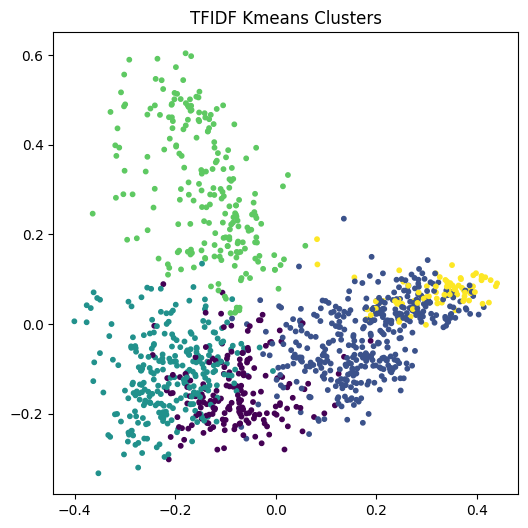

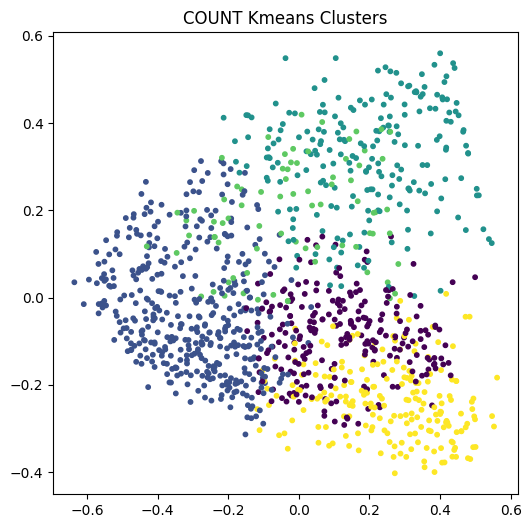

In [ ]:

#TFIDF
pca_cluster_plot(tfidf_X_train_reduced, tfidf_kmeans.labels_, "TFIDF Kmeans Clusters" )

#Count
pca_cluster_plot(count_X_train_reduced, count_kmeans.labels_, "COUNT Kmeans Clusters")


In [34]:
# Metrics to compare clustering with each dataset
# Adjusted Random Index Score (ARI) : measures how well clusters align with actual labels
# Silhouette Score : measures how close or dispersed the clusters are within themselves

ars_tfidf = adjusted_rand_score(y_train_labels,tfidf_kmeans.labels_) #true train labels vs kmeans cluster labels
sil_tfidf = silhouette_score(tfidf_X_train_reduced, tfidf_kmeans.labels_) 
print("TFIDF - Adjusted Random Score: ", round(ars_tfidf,5), " | Silhouette: ", round(sil_tfidf,5))

ars_count = adjusted_rand_score(y_train_labels, count_kmeans.labels_)
sil_count = silhouette_score(count_X_train_reduced, count_kmeans.labels_)
print("Count - Adjusted Random Score: ", round(ars_count,5), " | Silhouette: ", round(sil_count,5))




TFIDF - Adjusted Random Score:  0.66066  | Silhouette:  0.05557
Count - Adjusted Random Score:  0.35548  | Silhouette:  0.09157


What we're looking for in the data sets is as much accuracy as possible (highest ARI score) and ideally a nice clustering of data points within categories with clear delineation among clusters (high silhouette scores). 

We have the TFIDF data that maintains accuracy to the labels and categories than the COUNT data, but more disperse clusters than the COUNT data. 

Seeing the cluster graph and having metrics to measure each cluster, I will decide to work with the TFIDF Vectorized matrices for modeling. 

In [37]:
# Time to model! 
# I'd like to use the Agglomerative and NMF models I used in my original project submission, 
# in addition to a kmeans cluster model for baseline comparison. 
# I'll add a Gaussian Mixture Model as a consideration for articles or data points that *could* belong to multiple categories
# the GMM works as a type of baseline comparison model against the agglo and NMF models. 
# NMF is used because is decomposes documents into latent topics, which can often correspond to categories and can be strong for text clustering.


In [41]:
#Kmeans Model (trying with random init and k-means++)

# GMM

#Agglomerative Model (trying with cosine/complete, cosine/average, and euclidean/ward)

#NMF (trying with Frobenius and KL loss functions)
nmf = NMF(n_components=len(np.unique(y_train_labels)), random_state=88, max_iter=500)
nmf_X_train = nmf.fit_transform(tfidf_X_train)
nmf_X_val = nmf.transform(tfidf_X_val)

nmf_train_labels = np.argmax(nmf_X_train, axis=1)
nmf_val_labels = np.argmax(nmf_X_val, axis=1)

ari_nmf_train = adjusted_rand_score(y_train_labels, nmf_train_labels)
ari_nmf_val = adjusted_rand_score(y_val_labels, nmf_val_labels)

sil_nmf_train = silhouette_score(nmf_X_train, nmf_train_labels) 
sil_nmf_val = silhouette_score(nmf_X_val, nmf_val_labels) 

print(f"NMF Train - ARI: {ari_nmf_train:.4f}, Silhouette: {sil_nmf_train:.4f}")
print(f"NMF Val   - ARI: {ari_nmf_val:.4f}, Silhouette: {sil_nmf_val:.4f}")


NMF Train - ARI: 0.8759, Silhouette: 0.5699
NMF Val   - ARI: 0.9062, Silhouette: 0.5726


In [36]:
def evaluate_clustering(model, X, y_true, model_name):
    """
    Fits clustering model, computes ARI + Silhouette
    Returns results as dictionary
    """
    if hasattr(model, "fit_predict"):
        y_pred = model.fit_predict(X)
    else:  # Some models like NMF don't have fit_predict
        y_pred = model.fit(X).transform(X).argmax(axis=1)
    
    ari = adjusted_rand_score(y_true, y_pred)
    sil = silhouette_score(X, y_pred)
    
    return {
        "Model": model_name,
        "ARI": ari,
        "Silhouette": sil
    }

# list of models to test
models = [
    (KMeans(n_clusters=len(np.unique(y_train)), random_state=42), "KMeans"),
    (AgglomerativeClustering(n_clusters=len(np.unique(y_train))), "Agglomerative"),
    (GaussianMixture(n_components=len(np.unique(y_train)), random_state=42), "GMM"),
    #(NMF(n_components=len(np.unique(y_train)), random_state=42, max_iter=500), "NMF")
]

# evaluate all models
results = []
for model, name in models:
    res = evaluate_clustering(model, tfidf_X_train_reduced, y_train_labels, name)
    results.append(res)

# convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

           Model       ARI  Silhouette
0         KMeans  0.905279    0.067090
1  Agglomerative  0.760305    0.059908
2            GMM  0.905279    0.067090


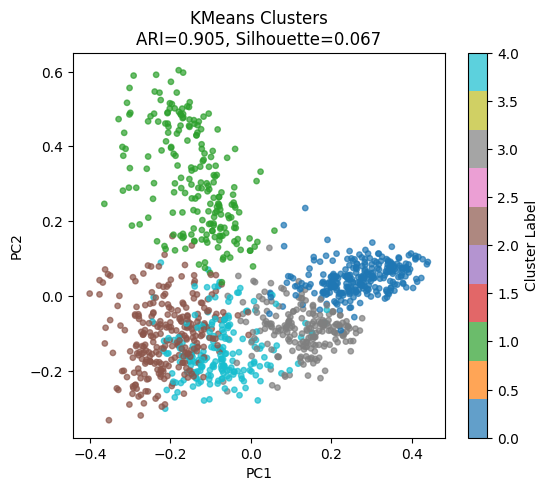

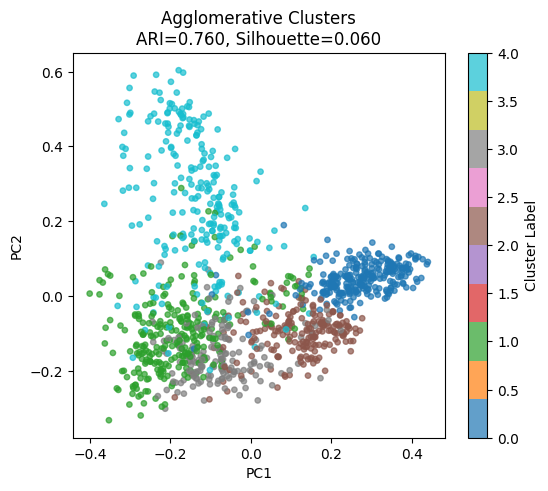

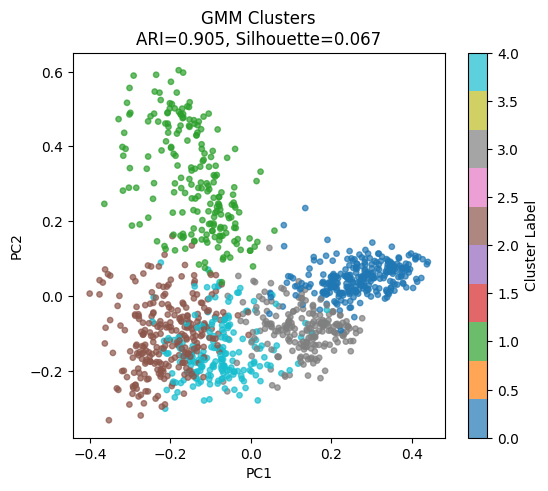


=== Results Summary ===
           Model       ARI  Silhouette
0         KMeans  0.905279    0.067090
1  Agglomerative  0.760305    0.059908
2            GMM  0.905279    0.067090


In [28]:
def evaluate_and_plot(model, X, y_true, model_name):
    """
    Fits clustering model, computes ARI + Silhouette, and plots PCA scatterplot
    """
    if hasattr(model, "fit_predict"):
        y_pred = model.fit_predict(X)
    else:  # e.g. NMF
        y_pred = model.fit(X).transform(X).argmax(axis=1)

    # Evaluation metrics
    ari = adjusted_rand_score(y_true, y_pred)
    sil = silhouette_score(X, y_pred)

    # Reduce to 2D with PCA for visualization
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    # Plot
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, cmap="tab10", s=15, alpha=0.7)
    plt.title(f"{model_name} Clusters\nARI={ari:.3f}, Silhouette={sil:.3f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter, label="Cluster Label")
    plt.show()

    return {
        "Model": model_name,
        "ARI": ari,
        "Silhouette": sil
    }

# Run evaluations + plots
results = []
for model, name in models:
    res = evaluate_and_plot(model, tfidf_X_train_reduced, y_train_labels, name)
    results.append(res)

# Collect results
results_df = pd.DataFrame(results)
print("\n=== Results Summary ===")
print(results_df)